In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test', 'sample_submission.csv', 'train.csv', 'train']


# Imports

In [2]:
import numpy as np
import pandas as pd
from keras.regularizers import l2
from sklearn.model_selection import train_test_split
from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.optimizers import Adam
import cv2
import matplotlib.pyplot as plt  
from tqdm import tqdm_notebook
import os

Using TensorFlow backend.


In [3]:
base_path = "../input/"

In [4]:
data_df = pd.read_csv(base_path+'train.csv')
data_df.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


# Sample Image

In [5]:
sample_image = cv2.imread("../input/train/train/008bd3d84a1145e154409c124de7cee9.jpg")

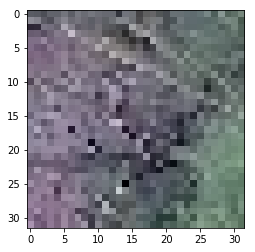

In [6]:
plt.imshow(sample_image)

# Pre-process Data

In [7]:
X=[]
y=[]
for index, ex in tqdm_notebook(data_df.iterrows()):
    name =  cv2.imread(base_path+'train/train/'+ex['id'])
    name = name/255 # Normalize b/w [0,1]
    label =  ex['has_cactus']
    X.append(name)
    y.append(label)
X = np.array(X)
y = np.array(y).reshape(-1,1)
X.shape, y.shape

((17500, 32, 32, 3), (17500, 1))

# Model Defination

In [8]:
epochs = 1000
batch_size = 64

In [9]:
model_vgg16 = VGG16(include_top = False,
                   #weights = 'imagenet',
                   input_shape = (32,32,3,))

Instructions for updating:
Colocations handled automatically by placer.
58892288/58889256 [==============================] - 2s 0us/step


In [10]:
#model_vgg16.trainable = False
model_vgg16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
__________

In [11]:
model = Sequential()
model.add(model_vgg16)
model.add(Flatten())
model.add(Dense(256, activation='relu', activity_regularizer=l2(0.001)))
model.add(Dense(128, activation='relu', activity_regularizer=l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [12]:
model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=0.00001),
              metrics=['accuracy'])

In [13]:
 history = model.fit(X, y,
                    validation_split=0.2,
                    epochs=epochs,
                    shuffle= True,
                    batch_size=batch_size,
                    verbose=2)

Instructions for updating:
Use tf.cast instead.
Train on 14000 samples, validate on 3500 samples
Epoch 1/1000
 - 12s - loss: 1.0300 - acc: 0.6889 - val_loss: 0.6666 - val_acc: 0.7491
Epoch 2/1000
 - 7s - loss: 0.6443 - acc: 0.7508 - val_loss: 0.6200 - val_acc: 0.7491
Epoch 3/1000
 - 7s - loss: 0.6037 - acc: 0.7511 - val_loss: 0.5865 - val_acc: 0.7491
Epoch 4/1000
 - 7s - loss: 0.5750 - acc: 0.7554 - val_loss: 0.5643 - val_acc: 0.7491
Epoch 5/1000


KeyboardInterrupt: 

In [ ]:
model.save('model_cactus.hdf5')

# Loss and Accuracy Graph

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["train", "validation"])

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["train", "validation"])

# Submission

In [ ]:
result_df = pd.DataFrame(columns=['id', 'has_cactus'])

In [ ]:
result = {}
for filepath in tqdm_notebook(os.listdir(base_path+"test/test/")):
    image = cv2.imread(base_path+"test/test/"+filepath)
    image = image/255
    result[filepath] = 1 if model.predict(image.reshape(-1, 32, 32, 3)) > 0.7 else 0

In [ ]:
for i, val in enumerate(result.items()):
    result_df.loc[i] = val

In [ ]:
result_df.to_csv("submission.csv", index = False)

# End